In [1]:
from environments.PlantSimulator import PlantSimulator
from utils.functions import PiecewiseLinear
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from scipy.optimize import curve_fit

## Section 1: Approximate a plant's actual area
We aim to convert the historic area measurements of a plant to "actual areas", which are the plant's true sizes at different times. This conversion is necessary to remove the effect of leaves' opening and closing throughout the day.

In [2]:
# Import historic leaf data
plant_id = 5
data_path = os.path.dirname(os.path.abspath("")) + '/analysis/plant_data/plant_all_data.csv'
all_df = pd.read_csv(data_path).sort_values(by='timestamp')
sub_df = all_df[all_df['plant_id'] == plant_id]  
data = np.array(sub_df['convex_hull_area'])

# Set params
steps_per_day = 72
steps_per_night = 72

### Method 1: Interpolate between daily max values
We assume that the maximal observed area in each day *is* the actual leaf area at that time stamp. We then interpolate between these time stamps, which all occur around the same time of the day. The interpolated function can be used to compute the actual area at any time. Note that we include night time in the interpolation.

best fit power law ~ x^2.82


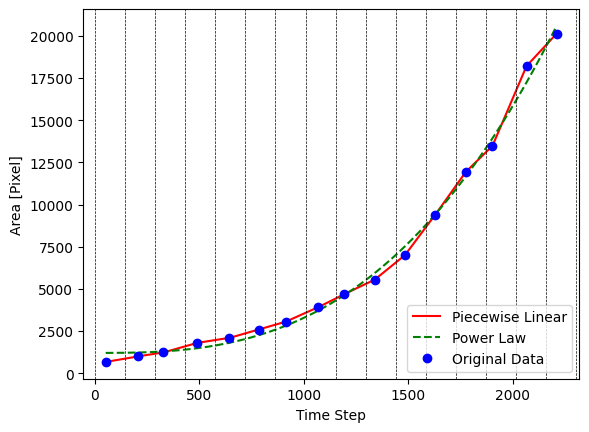

In [3]:
observed_area = np.reshape(data, (-1, steps_per_day))  # reshape into different days
max_indices = np.argmax(observed_area, axis=1)         # index at the max value of each day

max_time = []
max_area = []
for i in range(observed_area.shape[0]):
    max_time.append(i*(steps_per_day+steps_per_night) + max_indices[i])
    max_area.append(data[i*steps_per_day + max_indices[i]])

popt, pcov = curve_fit(lambda x, a, b, c: a * np.power(x, b) + c, max_time, max_area)
pwl = PiecewiseLinear(max_time, max_area)

x_values = np.linspace(max_time[0], max_time[-1], 1000) 
y_power = popt[0] * np.power(x_values, popt[1]) + popt[2]
print(f'best fit power law ~ x^{popt[1]:.2f}')
y_linear = [pwl(x) for x in x_values]

# Plot
plt.plot(x_values, y_linear, 'r-', label='Piecewise Linear')
plt.plot(x_values, y_power, 'g--', label='Power Law')
plt.plot(max_time, max_area, 'bo', label='Original Data') 
for i in range(int(len(data)/steps_per_day)+1):
    plt.axvline(x = (steps_per_day+steps_per_night)*i, color='k', linestyle='--', linewidth=0.5)
plt.xlabel('Time Step')
plt.ylabel('Area [Pixel]')
plt.legend()
plt.show()

Check how the interpolated function looks against the observed area, which is only available during daytime.

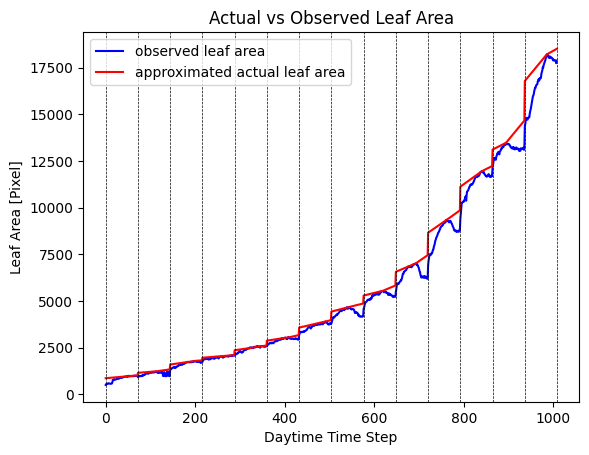

In [4]:
# Compute an array of actual area during daytime
actual_area_power = []
actual_area_linear = []
for i in range(1, observed_area.shape[0]-1):
    t0 = i*(steps_per_day + steps_per_night)
    t1 = t0 + steps_per_day
    x_values = np.arange(t0, t1)
    y_power_values = popt[0] * np.power(x_values, popt[1]) + popt[2]
    y_linear_values = [pwl(x) for x in x_values]
    actual_area_power.append(y_power_values)
    actual_area_linear.append(y_linear_values)
actual_area_power = np.hstack(actual_area_power)
actual_area_linear = np.hstack(actual_area_linear)

# Plot the actual vs observed area
plt.plot(observed_area.reshape(-1)[steps_per_day:-steps_per_day], 'b', label='observed leaf area')
plt.plot(actual_area_linear, 'r', label='approximated actual leaf area')
for i in range(int(len(data)/steps_per_day)-1):
    plt.axvline(x = (steps_per_day)*i, color='k', linestyle='--', linewidth=0.5)
plt.title(f'Actual vs Observed Leaf Area')
plt.xlabel('Daytime Time Step')
plt.ylabel('Leaf Area [Pixel]')
plt.legend()
plt.show()

## Section 2: Convert actual area to observed area
In the PlantSimulator environment, the function for computing the actual area will be modified at each time step in response to the agent's action. For example, if the agent turns the light off, the actual area could stop increasing for some period of time. 

The agent, however, will be measuring the observed area, so we need a way to convert actual area to observed area. We do so by multiplying the actual area by a "projection factor", defined as observed area / actual area, which we can compute from the plant's historic data. The projection factor should have the same characteristic shape every day if it successfully captures the plant's habit of opening & closing.

(0.0, 1008.0)

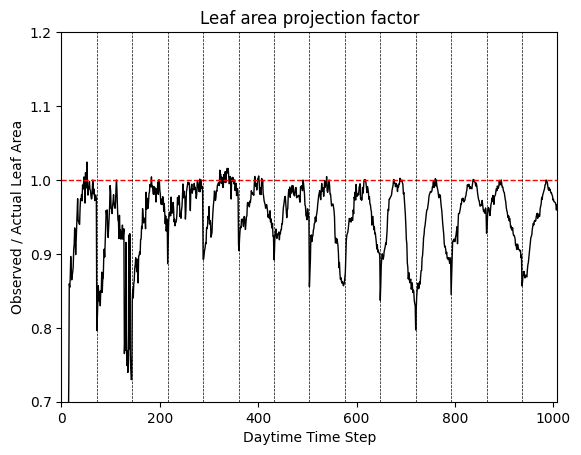

In [5]:
truncated_data = data[steps_per_day:-steps_per_day]
projection_factor = truncated_data/actual_area_linear

plt.plot(projection_factor, 'k', linewidth=1)
plt.plot(np.arange(len(projection_factor)), np.ones(len(projection_factor)), 'r--', linewidth=1)
for i in range(int(len(data)/steps_per_day)-1):
    plt.axvline(x = (steps_per_day)*i, color='k', linestyle='--', linewidth=0.5)
plt.title('Leaf area projection factor')
plt.xlabel(f'Daytime Time Step')
plt.ylabel(f'Observed / Actual Leaf Area')
plt.ylim(0.7,1.2)
plt.xlim(0,len(projection_factor))

Let's stack up everyday's projection factor, and see if they have the same characteristic shape

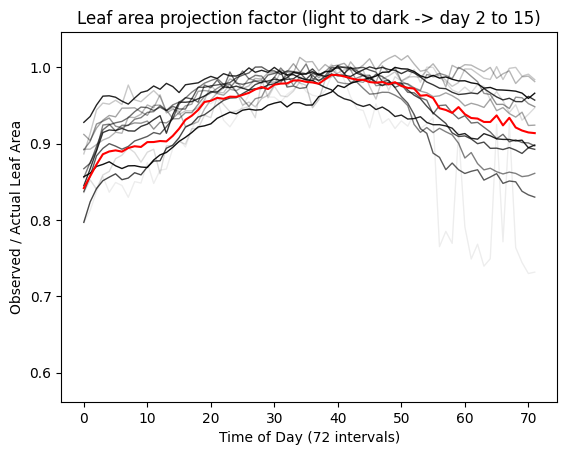

In [6]:
projection_factor = np.reshape(projection_factor, (-1, steps_per_day))  

for i in range(projection_factor.shape[0]):
    row = projection_factor[i]
    plt.plot(row, alpha=1/14*i, color='k', linewidth=1)
plt.plot(np.mean(projection_factor, axis=0), 'r', label='average projection factor')
plt.title('Leaf area projection factor (light to dark -> day 2 to 15)')
plt.xlabel(f'Time of Day ({steps_per_day} intervals)')
plt.ylabel(f'Observed / Actual Leaf Area')
plt.show()

(Optional) Since the projection factor as a function of "time of day" looks very similar every day, we COULD use the average (red) to convert actual data to observed data, and compare it to the original observed data. They should be fairly close. (It's also a good idea to use the noisy, raw projection factor without averaging. It will create a noisier environment that's closer to real life!)

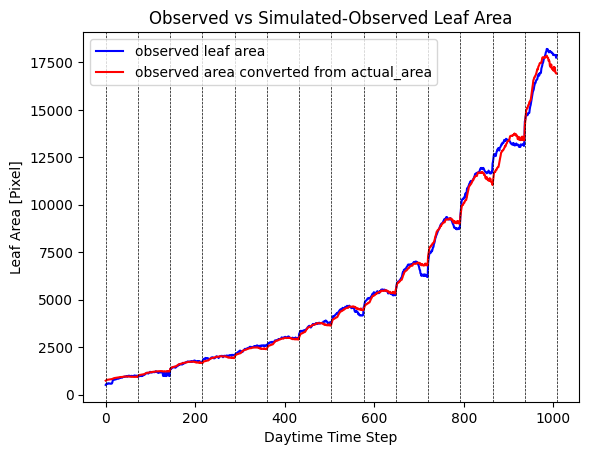

In [7]:
mean_projection_factor = np.mean(projection_factor, axis=0)

converted = []
for i in range(projection_factor.shape[0]):
    converted.append(actual_area_linear[i*steps_per_day:(i+1)*steps_per_day]*mean_projection_factor)
converted = np.hstack(converted)

plt.plot(observed_area.reshape(-1)[steps_per_day:-steps_per_day], 'b', label='observed leaf area')
plt.plot(converted, 'r', label='observed area converted from actual_area')
for i in range(int(len(data)/steps_per_day)-1):
    plt.axvline(x = (steps_per_day)*i, color='k', linestyle='--', linewidth=0.5)
plt.title(f'Observed vs Simulated-Observed Leaf Area')
plt.xlabel('Daytime Time Step')
plt.ylabel('Leaf Area [Pixel]')
plt.legend()
plt.show()


## Testing reward functions

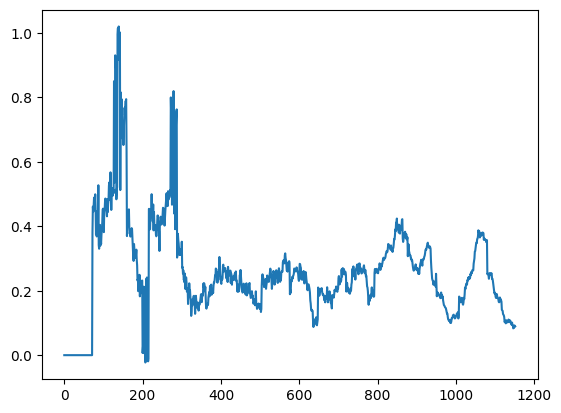

In [8]:
reward = np.zeros_like(data)  
n_steps = 72
# percentage growth over 24 hours
reward[n_steps:] = (data[n_steps:] - data[:-n_steps]) / data[:-n_steps]
plt.plot(reward)

## Misc: looking for other size indicator
Here we play around with PlantCV data to see if any combination of the measurements is monotonically increasing.

Index(['sample', 'image_name', 'timestamp', 'date', 'time', 'plant_id',
       'genotype', 'area', 'in_bounds', 'object_in_frame', 'perimeter',
       'height', 'width', 'solidity', 'center_of_mass_x', 'center_of_mass_y',
       'ellipse_center_x', 'ellipse_center_y', 'ellipse_major_axis',
       'ellipse_minor_axis', 'ellipse_angle', 'ellipse_eccentricity',
       'convex_hull_vertices', 'convex_hull_area', 'longest_path'],
      dtype='object')


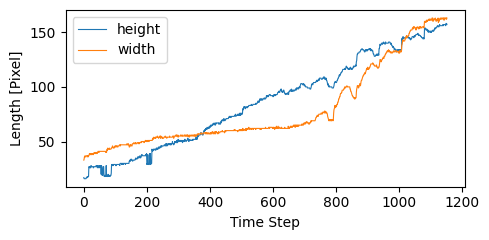

In [30]:
data_path = os.path.dirname(os.path.abspath("")) + '/analysis/plant_data/plant_all_data.csv'
all_df = pd.read_csv(data_path).sort_values(by='timestamp')
print(all_df.columns)

plant_id = 5
sub_df = all_df[all_df['plant_id'] == plant_id]  

area = np.array(sub_df['area'])
convex_area = np.array(sub_df['convex_hull_area'])
longest_path = np.array(sub_df['longest_path'])
peri =  np.array(sub_df['perimeter'])
height =  np.array(sub_df['height'])
width =  np.array(sub_df['width'])

#combo=area/peri
# Moving average (optional)
#window_size = 1
#area = np.convolve(area, np.ones(window_size)/window_size, mode='valid')
#peri = np.convolve(peri, np.ones(window_size)/window_size, mode='valid')


# Normalize for comparison
def normal(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))


fig, ax = plt.subplots(figsize=(5,2.5))
#plt.plot(peri, label='perimeter', linewidth=0.8)
#plt.plot(longest_path, label='longest_path', linewidth=0.8)
plt.plot(height, label='height', linewidth=0.8)
plt.plot(width, label='width', linewidth=0.8)


#plt.plot(convex_area, 'r', label='convex_area', linewidth=0.8)
#plt.plot(area, 'g' ,label='area', linewidth=0.8)


#plt.plot(combo, label='combo', alpha=0.5, linewidth=0.5)
plt.xlabel('Time Step')
plt.ylabel('Length [Pixel]')
plt.legend()
plt.tight_layout()